Finding the Efficient Frontier using
optimization with scipy

1. Import the libraries:

In [ ]:
!pip install yfinance

import yfinance as yf
import numpy as np
import pandas as pd


     |████████████████████████████████| 6.4 MB 18.8 MB/s 
     |████████████████████████████████| 63 kB 728 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


2. Set up the parameters:

In [ ]:
N_PORTFOLIOS = 10 ** 5
N_DAYS = 252
RISKY_ASSETS = ['FB', 'TSLA', 'TWTR', 'MSFT']
RISKY_ASSETS.sort()
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'

n_assets = len(RISKY_ASSETS)

3. Download the stock prices from Yahoo Finance:

In [ ]:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE, end=END_DATE, adjusted=True)

[*********************100%***********************]  4 of 4 completed


4. Calculate annualized average returns and the corresponding standard deviation:

In [ ]:
returns_df = prices_df['Adj Close'].pct_change().dropna()
avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

In [ ]:
np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, n_assets))
weights /= np.sum(weights, axis=1)[:, np.newaxis]

In [ ]:
portf_rtns = np.dot(weights, avg_returns)
portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(np.dot(weights[i].T,
                    np.dot(cov_mat, weights[i]))))
portf_vol = np.array(portf_vol)
portf_sharpe_ratio = portf_rtns / portf_vol

In [ ]:
portf_results_df = pd.DataFrame({'returns': portf_rtns,
                                    'volatility': portf_vol,
                                    'sharpe_ratio':
                                    portf_sharpe_ratio})

5. Simulate random portfolio weights:

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import scipy.optimize as sco

5. Define functions for calculating portfolio returns and volatility

In [ ]:
def get_portf_rtn(w, avg_rtns):
  return np.sum(avg_rtns * w)
def get_portf_vol(w, avg_rtns, cov_mat):
  return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

6. Define the function calculating the Efficient Frontier

In [ ]:
def get_efficient_frontier(avg_rtns, cov_mat, rtns_range):
    efficient_portfolios = []
    n_assets = len(avg_returns)
    args = (avg_returns, cov_mat)
    bounds = tuple((0,1) for asset in range(n_assets))
    initial_guess = n_assets * [1. / n_assets, ]
    for ret in rtns_range:
        constraints = ({'type': 'eq',
                    'fun': lambda x: get_portf_rtn(x, avg_rtns)
                    - ret},
                    {'type': 'eq',
                    'fun': lambda x: np.sum(x) - 1})
        efficient_portfolio = sco.minimize(get_portf_vol,
                    initial_guess,
                    args=args,
                    method='SLSQP',
                    constraints=constraints,
                    bounds=bounds)
        efficient_portfolios.append(efficient_portfolio)
    return efficient_portfolios

7. Define the considered range of returns

In [ ]:
rtns_range = np.linspace(-0.22, 0.32, 200)

8. Calculate the Efficient Frontier

In [ ]:
efficient_portfolios = get_efficient_frontier(avg_returns,
cov_mat,
rtns_range)

9. Extract the volatilities of the efficient portfolios

In [ ]:
vols_range = [x['fun'] for x in efficient_portfolios]

10. Plot the calculated Efficient Frontier, together with the simulated portfolios

[Text(0, 0.5, 'Expected Returns'),
 Text(0.5, 0, 'Volatility'),
 Text(0.5, 1.0, 'Efficient Frontier')]

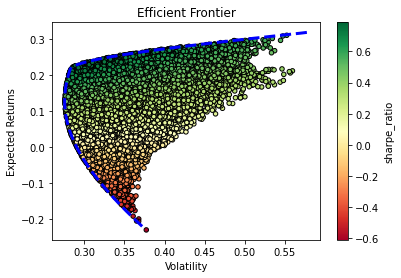

In [ ]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility',
                    y='returns', c='sharpe_ratio',
                    cmap='RdYlGn', edgecolors='black',
                    ax=ax)
ax.plot(vols_range, rtns_range, 'b--', linewidth=3)
ax.set(xlabel='Volatility',
                    ylabel='Expected Returns',
                    title='Efficient Frontier')

11. Identify the minimum volatility portfolio

In [ ]:
min_vol_ind = np.argmin(vols_range)
min_vol_portf_rtn = rtns_range[min_vol_ind]
min_vol_portf_vol = efficient_portfolios[min_vol_ind]['fun']

min_vol_portf = {'Return': min_vol_portf_rtn,'Volatility': min_vol_portf_vol,'Sharpe Ratio': (min_vol_portf_rtn /min_vol_portf_vol)}

12. Print the performance summary

In [ ]:
print('Minimum volatility portfolio ----')
print('Performance')

for index, value in min_vol_portf.items():
  print(f'{index}: {100 * value:.2f}% ', end="", flush=True)

print('\nWeights')
for x, y in zip(RISKY_ASSETS, efficient_portfolios[min_vol_ind]['x']):
  print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum volatility portfolio ----
Performance
Return: 13.01% Volatility: 27.54% Sharpe Ratio: 47.22% 
Weights
FB: 18.65% MSFT: 77.34% TSLA: 4.01% TWTR: 0.00% 

13. Define the objective function (negative Sharpe ratio)

In [ ]:
def neg_sharpe_ratio(w, avg_rtns, cov_mat, rf_rate):
    portf_returns = np.sum(avg_rtns * w)
    portf_volatility = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))
    portf_sharpe_ratio = (  portf_returns - rf_rate)/portf_volatility
    return -portf_sharpe_ratio

14. Find the optimized portfolio

In [ ]:
n_assets = len(avg_returns)
RF_RATE = 0
args = (avg_returns, cov_mat, RF_RATE)
constraints = ({'type': 'eq',
                'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0,1) for asset in range(n_assets))
initial_guess = n_assets * [1. / n_assets]
max_sharpe_portf = sco.minimize(neg_sharpe_ratio,
                                x0=initial_guess,
                                args=args,
                                method='SLSQP',
                                bounds=bounds,
                                constraints=constraints)

15. Extract information about the maximum Sharpe ratio portfolio

In [ ]:
max_sharpe_portf_w = max_sharpe_portf['x']
max_sharpe_portf = {'Return': get_portf_rtn(max_sharpe_portf_w,
                                            avg_returns),
                    'Volatility': get_portf_vol(max_sharpe_portf_w,
                                                avg_returns,
                                                cov_mat),
                    'Sharpe Ratio': -max_sharpe_portf['fun']}

16. Print the performance summary

In [ ]:
print('Maximum Sharpe Ratio portfolio ----')
print('Performance')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, max_sharpe_portf_w):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
Return: 23.10% Volatility: 29.25% Sharpe Ratio: 78.97% 
Weights
FB: 0.00% MSFT: 81.50% TSLA: 2.79% TWTR: 15.72% 